### Imports and Setup

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import copy
import datetime

# sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# modAL
from modAL.disagreement import max_std_sampling
from modAL.models import ActiveLearner, CommitteeRegressor

# scipy
from scipy import sparse

# custom package
from packages.activelearning import activelearning as al


### Set random seed
seed = 5
random.seed(seed)
np.random.seed(seed)

### Suppresses Warning
import warnings
warnings.filterwarnings('ignore')

# 1.1. Data Load (5 points)
**In this question, you need to build a regression model with active learning for predicting binding affinity between MHC class I and small peptides. The dataset is provided in file `hw3_data.csv`.**

**TODO**
- **Read the data into the jupyter notebook. Columns 2 and 3 in the dataset file correspond to peptide sequences and pIC50 values.**

### Load Data

In [2]:
data = pd.read_csv('data/hw3_data.csv', delimiter=',',header=0)
print(data.shape)
data.head(5)

(9051, 4)


,id,allele,seq,pIC50
0,seq0,HLA-A*02:01,AIIDYIAYM,9.0
1,seq1,HLA-A*02:01,AIYDTMQYV,9.0
2,seq2,HLA-A*02:01,ALATFTVNI,9.0
3,seq3,HLA-A*02:01,ALDEGLLPV,9.0
4,seq4,HLA-A*02:01,ALFPIIWAL,9.0


# 1.2. Encode Data (10 points)
**Since we are dealing with machine learning models, you need to convert peptide sequences into feature vectors. The simplest way to do this is to use a one-hot encoding.**

**Each character in the amino acid alphabet will correspond to a binary vector with a single 1 and all zeros. The size of the vector is equal to the size of the amino acid alphabet. The position of 1 encodes a specific amino acid. The resulting feature vector for a peptide is a concatenation of the feature vectors of its amino acids. Since we are dealing with 9-mers here, the size of the feature vector for a peptide should be equal to 9*(size of the amino acid alphabet).**

**TODO**
- **Encode the data.**
- **Split data into train and test datasets.**

### Encode Data

In [3]:
data['seq'].str.len().unique()  # every seq is length 9

array([9])

In [4]:
# create separate columns for each amino acid
for i in range(9):
    colname='seq'+str(i)
    data[colname] = [x[i] for x in data['seq']]

In [5]:
data.head(1)

,id,allele,seq,pIC50,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8
0,seq0,HLA-A*02:01,AIIDYIAYM,9.0,A,I,I,D,Y,I,A,Y,M


In [6]:
# number of unique letters
len(data['seq0'].unique())

20

In [9]:
# split into features and target
X_df = data.drop(['pIC50','id','allele', 'seq'],axis=1) # eliminate columns which are irrelevant
y = data['pIC50']
print(X_df.shape)
print(y.shape)

(9051, 9)
(9051,)


In [10]:
X_df.head(1)

,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8
0,A,I,I,D,Y,I,A,Y,M


In [11]:
enc = OneHotEncoder(handle_unknown='ignore')
X_enc = enc.fit_transform(X_df)
print(type(X_enc))
print(X_enc.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(9051, 180)


In [12]:
# convert to numpy array
X_pool=sparse.csr_matrix.toarray(X_enc)
print(type(X_pool))
print(X_pool.shape)
y_pool = y.to_numpy()
print(y_pool.shape)

<class 'numpy.ndarray'>
(9051, 180)
(9051,)


### Split Data
- X_train: 2/3 of data pool
- X_test: 1/3 of data pool

In [13]:
# split remaining pool of data
X_train, X_test, y_train, y_test = train_test_split(X_pool, y_pool, test_size=0.33)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6064, 180)
(6064,)
(2987, 180)
(2987,)


# 1.3. Build Active Learning  model (20 points)
**Now you can start building the model with active learning! We do not give you any specific instructions as to which algorithm to implement. You can use something similar to [this](https://modal-python.readthedocs.io/en/latest/content/examples/active_regression.html) example in modAL documentation, or query-by-committee when a label is requested for samples which the committee is least confident about or anything else covered in the lectures.**

**TODO**
- **Implement an active learning algorithm using modAL.**

In [1]:
# I implemented my Active Learning model as a Python package
# I implemented a second package to grid search over hyperparameters

In [14]:
def save_history_to_file(filename, history):
    '''
    Writes history to file.
    
    Args:
        filename: name of the file
        history: list of scores
    ''' 
    df = pd.DataFrame({'r2': history} )  
    df.to_csv(filename) 

### Run model with RBF kernel

In [15]:
%%time
# 56 min for 400 with 10 learners, length_scale=0.5, 0.475 at 100 queries
# 50 min for 400 with 10 learners, length_scale=2.769, 0.560 at 100 queries (test)
# 6.5 hours for 1000 with 10 learners, length_scale=2.769

# make a copy of the data for use in this section
X_pool_rbf = copy.deepcopy(X_train)
y_pool_rbf = copy.deepcopy(y_train)

# build active learner
kernel = RBF(length_scale=2.769,length_scale_bounds=(1e-2, 1e3))
n_learner = 10
n_initial = 80
committee_rbf = al.build_committee(kernel, n_learner, n_initial, X_pool_rbf, y_pool_rbf, seed)

# perform active learning
n_queries = 1000
history_rbf = al.run_and_score_active_learner_regression(committee_rbf, 
                                                         X_pool_rbf, 
                                                         y_pool_rbf, 
                                                         X_test, 
                                                         y_test, 
                                                         n_queries)


CPU times: user 21h 51min 39s, sys: 9min 51s, total: 22h 1min 31s
Wall time: 6h 30min 33s


In [16]:
# save results
filename = 'data/fullrun.rbf_2.769_' + datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') + '.csv'
save_history_to_file(filename, history_rbf)

### Run model with Matern kernel

In [18]:
%%time
# 58 min for 400 with 10 learners
# 7.5 hours for 1000 with 10 learners

# make a copy of the data for use in this section
X_pool_mat = copy.deepcopy(X_train)
y_pool_mat = copy.deepcopy(y_train)

# build active learner
kernel = Matern(length_scale=0.64, nu=1.5)
n_learner = 10
n_initial = 80
committee_mat = al.build_committee(kernel, n_learner, n_initial, X_pool_mat, y_pool_mat, seed)

# perform active learning
n_queries = 1000
history_mat = al.run_and_score_active_learner_regression(committee_mat, 
                                                         X_pool_mat, 
                                                         y_pool_mat, 
                                                         X_test, 
                                                         y_test, 
                                                         n_queries)


CPU times: user 1d 1h 22min 59s, sys: 17min 50s, total: 1d 1h 40min 49s
Wall time: 7h 35min 19s


In [19]:
# save results
filename = 'data/fullrun.matern_0.64_' + datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') + '.csv'
save_history_to_file(filename, history_mat)

# 1.4. Score model (5 points)
**The quality of the model should be measured on the test set as $R^2$ score. The minimum acceptable $R^2$ score is 0.6.**

**TODO**
- **Score the model on the test set using $R^2$.**

### Model with RBF kernel

In [17]:
# score the final model
r2 = al.score_regression_model(committee_rbf, X_test,y_test)
print("R2 for test set",r2) # 0.6126014746782097


# compare against R2 of the remaining pool
r2_pool = al.score_regression_model(committee_rbf, X_pool_rbf,y_pool_rbf)
print("R2 for pool",r2_pool) # 0.677571218738872

R2 for test set 0.6126014746782097
R2 for pool 0.677571218738872


### Model with Matern kernel

In [20]:
# score the final model
r2 = al.score_regression_model(committee_mat, X_test,y_test)
print("R2 for test set",r2)


# compare against R2 of the remaining pool
r2_pool = al.score_regression_model(committee_mat, X_pool_mat,y_pool_mat)
print("R2 for pool",r2_pool)

R2 for test set 0.5989614229925406
R2 for pool 0.6665529679520565


# 1.5. Compare with Random Active Learner (5 points)
**TODO**
- **Compare your results with no active learning scheme by training a random forest regressor on the same amount of data points, but selected randomly. (An active learner with a random query strategy.)**

In [21]:
class RfWrapper(RandomForestRegressor):  # superclass
    def predict(self, X, return_std = False):
        if return_std:
            ys = np.array([e.predict(X) for e in self.estimators_])
            return np.mean(ys, axis = 0).ravel(), np.std(ys, axis = 0).ravel()
        return super().predict(X).ravel()

In [22]:
def random_query(learner, X):
   
    n_samples = len(X)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X[query_idx]

### Run random learner

In [36]:
%%time
# 4 min for 1000 with 66 estimators and depth 9

# copy data for this section
X_pool_rand = copy.deepcopy(X_train)
y_pool_rand = copy.deepcopy(y_train)


# use the same initialization size to make comparison meaningful
n_initial = 80
initial_idx = []
for i in range(1):
    initial_idx.append(np.random.choice(len(X_pool_rand), size=n_initial, replace=False))
initial_rand = initial_idx[0]

regressor = ActiveLearner(
    estimator=RfWrapper(n_estimators = 66, max_depth = 9, random_state = seed),
    query_strategy=random_query,
    X_training=X_pool_rand[initial_rand], 
    y_training=y_pool_rand[initial_rand]
)


# run learner
n_queries = 1000
history_rand = al.run_and_score_active_learner_regression(regressor, 
                                                          X_pool_rand, 
                                                          y_pool_rand, 
                                                          X_test, 
                                                          y_test, 
                                                          n_queries)


CPU times: user 3min 47s, sys: 1.87 s, total: 3min 49s
Wall time: 3min 50s


### Score random learner

In [37]:
# score the final model

r2=al.score_regression_model(regressor, X_test,y_test)
print("R2 for test set",r2)

# compare against R2 of the remaining pool
r2_pool=al.score_regression_model(regressor, X_pool_rand,y_pool_rand)
print("R2 for pool",r2_pool)

R2 for test set 0.45336118473285525
R2 for pool 0.5376522968728146


### Compare against active learners

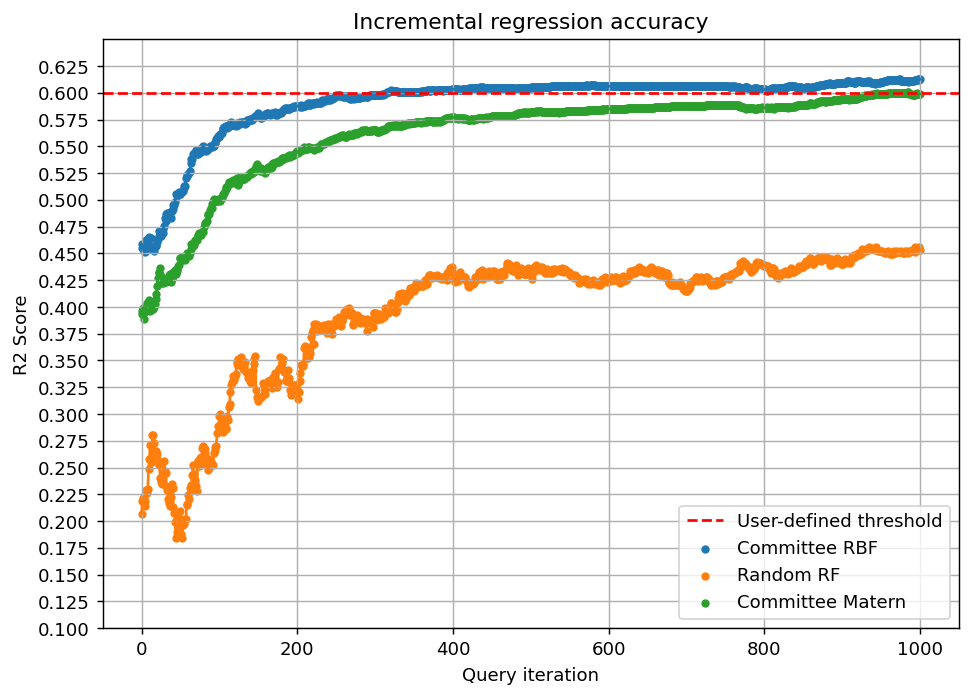

In [38]:
# compare the two results
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_rbf)
ax.scatter(range(len(history_rbf)), history_rbf, s=13, label = 'Committee RBF')

ax.plot(history_rand)
ax.scatter(range(len(history_rand)), history_rand, s=13, label = 'Random RF')

ax.plot(history_mat)
ax.scatter(range(len(history_mat)), history_mat, s=13, label = 'Committee Matern')

ax.grid(True)

ax.set_title('Incremental regression accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('R2 Score')
ax.set_ylim([0.2,.65])
ax.axhline(y=0.6, color='red', linestyle='--', label='User-defined threshold')

ax.legend()
plt.yticks(np.arange(.1, 0.65, step=0.025)) 
plt.show()

# 1.6. Summary (5 points)
**TODO**
- **Write a paragraph about your method, describe your observations and difficulties.**

### Method
I encoded the data by separating the sequence into individual letters and performing one-hot encoding. I removed all all feature columns because this data was for a single HLA allele. I did not standardize the pIC50 values.

I experimented with a number of regressors, and I chose to use Gaussian Process because it was the highest performing regressor on the full training set. I also experimented with a number of kernel combinations, and I chose to use RBF and Matern kernels because they were the highest performing kernels on the full training set. I used a committee-based approach because I anticipated that using only a small amount of training data during active learning meant each model would be a weak regressor. I predicted a committee-based approach would combine the efforts of multiple models and result in an overall better model. I chose to have all committee members be the same type of active learner, and I used standard deviation sampling as the query strategy.

The next step was to tune the model's hyperparameters. I experimented with the following hyperparameters: (1) number of committee members; (2) number of initial training instances for each active learner; (3) all kernel parameters. 

Using a grid search, I found that increasing the number of committee members from 2 to 10 improved $R^2$ scores, and that after 10 members, gains were neglible. I found that increasing the number of initial training instances greatly improved $R^2$ scores, but any gains past `n_initial=80` were neglible. For the RBF kernel, I tuned `length_scale` and `length_scale_bounds`. I found that decreasing `length_scale_bounds` allowed the model to run faster, but had little effect on the scores. After extensive searching over `length_scale`, I chose a value which was associated with the consistently high $R^2$ scores (above 0.55 at 100 queries). For the Matern kernel, I tuned `length_scale` and `nu`. I found that modifying `nu` from its default value of 1.5 led to decreased performance. After searching over `length_scale`, I chose a value which was associated with the consistently high $R^2$ scores (above 0.52 at 100 queries).

I ran the final model using a commitee of Gaussian Process regressors which all had the same kernel, and compared performance against the random active learner. Note that I set the hyperparameters of the random forest regressor based on a grid search.

![image.png](img/gridsearch2/4.3_estimators_vs_max_depth_heatmap.png)


### Observations
There are a number of observations which could be made about the process and the results.

#### Process
- I found it was very important to save to file all results from the grid search and organize them according to experiment run. Without a record of what had been tried, it was possible to duplicate efforts. If results weren't organized, it was difficult to tell whether progress was being made and how to explain the narrative of how you arrived at your results.
- I found it was important to fix all other hyperparameters in order to study how each hyperparameter changed. For example, if I wanted to understand how modifying `length_scale` of my kernel affected $R^2$ scores, I needed to eliminate the possibility that changes to the score were related to size of the initial training set or number of committee members.
- I found it was important to begin with a wide grid search before narrowing into specific ranges. Without this, I might fail to consider values in a region which could contain the global optimum. 
- I found it was important to using a smaller number of queries for hyperparameter tuning. A small number of queries meant that I could perform more experiments to determine the best values.

#### Results
- With Gaussian Process using the RBF kernel, I was able to achieve $R^2$ within 315 queries. With Gaussian process using the Matern kernel, it took 971 queries to achieve the same. Both RBF and Matern kernels performed well, with Matern seeing greater improvement over time.
- I found that the active learner performed better than the random learner, but much of this had to do with the starting point. All learners seemed to learn at about the same rate, which surprising given the Random Forest regressor is getting random data points. This points to the idea that the samples being selected via active learning are about as useful as a random value - maybe the data encoding could be improved to change this.


### Difficulties
I faced a number of challenges in this process. 
- I do not have a background in active learning regression or kernels, so I didn't have intuition as to which regressor or kernel might work well. There are too many possible options to approach this problem through brute force alone, so I often had to settle for "good enough" to keep moving forward. 
- Tuning kernel hyperparameters proved very challenging. Kernel parameters are real-valued (infinite range of values), runs took a long time (approx. 10-20 minutes per 100 queries), and resulting scores were somewhat stochastic even after using a random seed. I could only perform a small number of runs with a limited number of queries, and I needed to be very selective about the kernel parameter ranges I studied. After collecting a large amount of results, it was hard to clearly discern which values were optimal. It was also difficult to determine whether the results I was seeing after 100 queries were predictive of model performance at 200 queries or higher. I failed to achieve an $R^2$ score of 0.60 during searching, so I could only anticipate which values would achieve the desired result. I tried over 600 different combinations of hyperparameters and only made a small dent in the search space. Once again, I had to settle for "good enough" to keep moving forward.
![image.png](img/gridsearch1/3.10_scatterplot_all.png)
- The stochastic nature of the Gaussian Process made it difficult to reproduce results I had seen during testing. For example, with my first full run with the RBF kernel, I got 0.475 at 100 queries when I was able to achieve 0.55 on 100 queries during testing. Previous runs using the same length_scale with which I exceeded $R^2=0.6$ only achieved 0.58.
- The biggest challenge was determining whether I could further improve $R^2$ after reaching the limits of the current model. There appeared to be a clear asymptotic limit to the performance of my chosen models. In other words, hyperparameter tuning could only do so much. In order to make significant improvements, I would likely need to change my approach entirely. But would it make a difference? Any attempts at this seemed like a shot in the dark - there were too many options: Should I alter the encoding of my data to include relationship between amino acids (i.e. protein shape)? Should I use a different regressor? Should I use a single model instead of a committee? Should I be using a different query strategy? Long run times meant I could not try everything.


### Follow-Up
It may be possible to improve the results further by encoding the order of the amino acids. The 3D structure they form is vital for binding, and structure is determined by sequence order. One possible way is to group letters in order. How do I decide how many letters constitutes a group?

Ex: 3-mers
```
AIIDYIAYM
AII
 IID
  IDY
    ...
      AYM
```

3-mers results in N < J, where N is the number of samples and J is the number of features. If we want to use multivariate regression, we'll need to use ridge regression or some other sparse form.


In [7]:
# # create triplets
# k = 3
# count = 9-k+1
# start=0
# end=k
# for i in range(count):
#     colname='triplet'+str(i)
#     data[colname] = [x[start:end] for x in data['seq']]
#     start +=1
#     end +=1